Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import geopandas as gpd
from shapely.geometry import Polygon

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col=0)
df_main

,rgiid,x,y,Surge,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff
206,RGI60-07.00004,524657.521964,8.539931e+06,0,1.044,13.8,0,NaN,889.68555,25.314478,915.00000,432.103017,0.005069,1.392706,279.780932,1.100061
207,RGI60-07.00004,524681.113471,8.539955e+06,0,1.044,13.8,0,NaN,882.06460,30.935455,913.00000,432.421537,0.005068,1.391001,295.980219,1.094416
208,RGI60-07.00004,524704.704977,8.539980e+06,0,1.044,13.8,0,NaN,882.06460,30.935455,913.00000,432.740057,0.005068,1.389296,330.851846,1.088771
209,RGI60-07.00004,524728.296484,8.540004e+06,0,1.044,13.8,0,NaN,882.06460,30.935455,913.00000,433.058576,0.005067,1.387591,342.886985,1.083127
210,RGI60-07.00004,524751.887990,8.540028e+06,0,1.044,13.8,0,NaN,881.31860,34.681380,916.00000,433.377096,0.005067,1.385886,336.403639,1.077530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130984,RGI60-07.01567,534269.488654,8.675206e+06,3,5.350,11.7,0,Moeysalbreen,237.64468,50.380424,288.02512,627.625366,0.004612,-1.412920,278.553621,2.123592
130985,RGI60-07.01567,534310.362510,8.675249e+06,3,5.350,11.7,0,Moeysalbreen,233.07228,46.717087,279.78937,627.625366,0.004614,-1.423469,256.755923,2.127417
130986,RGI60-07.01567,534309.250485,8.675291e+06,3,5.350,11.7,0,Moeysalbreen,233.07228,46.717087,279.78937,627.625366,0.004618,-1.395654,238.477978,2.076787
130987,RGI60-07.01567,534308.138459,8.675333e+06,3,5.350,11.7,0,Moeysalbreen,233.18828,47.159560,280.34784,627.625366,0.004620,-1.382369,226.342325,2.005969


In [4]:
df_main['SMB_calc'] = df_main['beta']*(df_main['surface_elevation']-df_main['ELA'])
df_main

,rgiid,x,y,Surge,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff,SMB_calc
206,RGI60-07.00004,524657.521964,8.539931e+06,0,1.044,13.8,0,NaN,889.68555,25.314478,915.00000,432.103017,0.005069,1.392706,279.780932,1.100061,2.447634
207,RGI60-07.00004,524681.113471,8.539955e+06,0,1.044,13.8,0,NaN,882.06460,30.935455,913.00000,432.421537,0.005068,1.391001,295.980219,1.094416,2.435692
208,RGI60-07.00004,524704.704977,8.539980e+06,0,1.044,13.8,0,NaN,882.06460,30.935455,913.00000,432.740057,0.005068,1.389296,330.851846,1.088771,2.433887
209,RGI60-07.00004,524728.296484,8.540004e+06,0,1.044,13.8,0,NaN,882.06460,30.935455,913.00000,433.058576,0.005067,1.387591,342.886985,1.083127,2.432082
210,RGI60-07.00004,524751.887990,8.540028e+06,0,1.044,13.8,0,NaN,881.31860,34.681380,916.00000,433.377096,0.005067,1.385886,336.403639,1.077530,2.445479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130984,RGI60-07.01567,534269.488654,8.675206e+06,3,5.350,11.7,0,Moeysalbreen,237.64468,50.380424,288.02512,627.625366,0.004612,-1.412920,278.553621,2.123592,-1.566323
130985,RGI60-07.01567,534310.362510,8.675249e+06,3,5.350,11.7,0,Moeysalbreen,233.07228,46.717087,279.78937,627.625366,0.004614,-1.423469,256.755923,2.127417,-1.604864
130986,RGI60-07.01567,534309.250485,8.675291e+06,3,5.350,11.7,0,Moeysalbreen,233.07228,46.717087,279.78937,627.625366,0.004618,-1.395654,238.477978,2.076787,-1.606379
130987,RGI60-07.01567,534308.138459,8.675333e+06,3,5.350,11.7,0,Moeysalbreen,233.18828,47.159560,280.34784,627.625366,0.004620,-1.382369,226.342325,2.005969,-1.604294


In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
# df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

# Calculate the slope

In [6]:
df_main[df_main['rgiid']=='RGI60-07.00006']

,rgiid,x,y,Surge,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff,SMB_calc,WH,dummy
289,RGI60-07.00006,537467.580455,8.536842e+06,0,13.618,12.6,1,Chomjakovbreen,591.491460,24.508570,616.0,503.103638,0.006668,0.025495,1098.398114,1.653396,0.752798,44.816899,0.097009
290,RGI60-07.00006,537404.091767,8.536902e+06,0,13.618,12.6,1,Chomjakovbreen,591.491460,24.508570,616.0,503.103638,0.006670,0.082867,1141.233362,1.586801,0.753056,46.564665,0.851208
291,RGI60-07.00006,537340.603079,8.536963e+06,0,13.618,12.6,1,Chomjakovbreen,565.438700,23.561293,589.0,503.103638,0.006673,0.140240,1144.919151,1.520206,0.573153,48.593222,0.816803
292,RGI60-07.00006,537277.114391,8.537023e+06,0,13.618,12.6,1,Chomjakovbreen,547.375400,24.624578,572.0,503.103638,0.006675,0.197612,1105.995748,1.453610,0.459876,44.914303,0.984317
293,RGI60-07.00006,537213.625703,8.537084e+06,0,13.618,12.6,1,Chomjakovbreen,514.921600,27.078419,542.0,503.103638,0.006679,0.202483,1069.477866,1.434204,0.259794,39.495580,0.749262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,RGI60-07.00006,534157.361970,8.542901e+06,0,13.618,12.6,1,Chomjakovbreen,25.731995,45.268005,71.0,490.177887,0.005759,-1.815483,1101.921164,2.196178,-2.414010,24.342163,0.888997
393,RGI60-07.00006,534155.855725,8.542963e+06,0,13.618,12.6,1,Chomjakovbreen,9.417454,48.582546,58.0,490.124972,0.005741,-1.854419,1120.747012,2.221797,-2.480841,23.068923,0.159969
394,RGI60-07.00006,534154.349476,8.543025e+06,0,13.618,12.6,1,Chomjakovbreen,-8.556934,52.556934,44.0,489.669604,0.005742,-1.891861,1137.258398,2.247416,-2.558871,21.638599,0.294415
395,RGI60-07.00006,534152.843224,8.543087e+06,0,13.618,12.6,1,Chomjakovbreen,-8.556934,52.556934,44.0,489.214236,0.005742,-1.929303,1131.680409,2.273035,-2.556526,21.532466,0.491542


In [7]:
df_main[df_main.rgiid=='RGI60-07.00006'].shape[0]

108

In [8]:
df = pd.DataFrame({'surface_slope':[1, 2, 3, 4]})
df['surface_slope'].to_list()

[1, 2, 3, 4]

5.856958478658212
289    12.6
290    12.6
291    12.6
292    12.6
293    12.6
       ... 
392    12.6
393    12.6
394    12.6
395    12.6
396    12.6
Name: Slope, Length: 108, dtype: float64


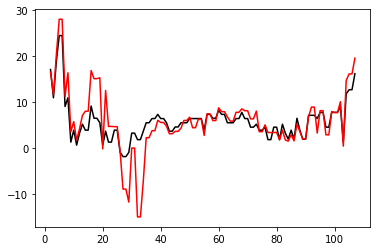

In [13]:
def get_slope(data):
    n_windows = data.shape[0]
#     gb = data.groupby(data.index // (data.shape[0]/n_windows))
    length = []
    bed = []
    surface = []
    bed_slope = [np.nan]
    surface_slope = [np.nan]
    for i in np.arange(0, n_windows-1):
    #     print(i)
        length.append(np.sqrt((data.x.values[i] 
                                - data.x.values[i+1])**2
                                 + (data.y.values[i]
                                - data.y.values[i+1])**2))
        bed.append(data.bed.values[i]-data.bed.values[i+1])
        surface.append(data.surface_elevation.values[i]
                       -data.surface_elevation.values[i+1])
        bed_slope.append(np.degrees(np.arctan(bed[i]/length[i])))
        surface_slope.append(np.degrees(np.arctan(surface[i]/length[i])))
#         bed_slope.append(np.arctan(bed[i]/length[i]))
#         surface_slope.append(np.arctan(surface[i]/length[i]))
#     print(data.rgiid.unique()[0], bed_slope.shape, surf_slope.shape)
#     bed_slope = pd.DataFrame({'Bed_slope':bed_slope})
#     surface_slope = pd.DataFrame({'Surface_slope':surface_slope})
#     print(data.rgiid.unique()[0], bed_slope.shape, surface_slope.shape)
#     print(surface_slope)
    
#     plt.plot(data.surface_elevation.values, 'k')
#     plt.plot(data.bed.values, 'r')
    
    df = pd.DataFrame({'surface_slope':surface_slope})
    df_surf = df.replace(to_replace=0.000000, method='ffill')
#     print(df_surf)
    surface_slope = df_surf['surface_slope'].tolist()
    print(np.nanmean(surface_slope))
    
    df = pd.DataFrame({'bed_slope':bed_slope})
    df_bed = df.replace(to_replace=0.000000, method='ffill')
    bed_slope = df_bed['bed_slope'].tolist()
    
    plt.plot(surface_slope, 'k')
    plt.plot(bed_slope, 'r')
    
    return {
        'bed_slope':bed_slope
        , 'surface_slope':surface_slope
        , 'length': length
    }
get_slope(df_main[df_main.rgiid=='RGI60-07.00006'])
print(df_main[df_main.rgiid=='RGI60-07.00006'].Slope)

31.993097919407106
5.856958478658212
17.251566372793643
29.30798123745539
19.536061987346226
0.8332760690714393
1.2704271201466906
0.6526053856029637
1.4294739395839018
0.9879177864060926
1.3098044006793017
1.2324200479242695
5.108037829990103
3.353373524969354
1.7246736732095744
1.5026035600517675
2.7584115246388223
2.1138844632915568
2.136312315756887
3.151872760653107
1.719554193821849
1.209778966417098
1.9536974245595071
2.2624259537236227
10.744217865848952
2.031334207576361
16.52137806996468
15.511458919516592
9.02101990874116
8.63594700826907
18.836257349632263
7.420871354522181
5.218793918974122
10.662715936778424
1.7283923315575185
1.7728340390597193
0.8129600895207593
4.6718047680731045
2.73878767343481
2.739038397663728
2.4767276447620996
5.230761098050371
4.029629746342341
6.131498426206265
2.8981166337906736
4.935258424793582
5.515294989998055
6.606693889092973
12.775358202925004
7.079123657351095
4.953117596808886
7.695793280529506
14.332442408036417
14.147529586033697
20

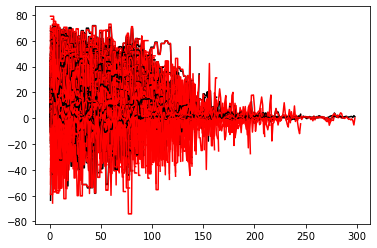

In [14]:
sloped = df_main.groupby('rgiid').apply(get_slope)

In [15]:
test = pd.DataFrame({'rgiid':sloped.index[0], 'Bed_slope':sloped['RGI60-07.00004']['bed_slope'], 'Surface_slope':sloped['RGI60-07.00004']['surface_slope']})
test

,rgiid,Bed_slope,Surface_slope
0,RGI60-07.00004,NaN,NaN
1,RGI60-07.00004,12.654898,3.372262
2,RGI60-07.00004,12.654898,3.372262
3,RGI60-07.00004,12.654898,3.372262
4,RGI60-07.00004,1.259105,-5.051115
5,RGI60-07.00004,15.003054,14.036142
6,RGI60-07.00004,15.003054,14.036142
7,RGI60-07.00004,15.003054,14.036142
8,RGI60-07.00004,15.003054,14.036142
9,RGI60-07.00004,27.496049,26.564878


In [12]:
df_slope = pd.DataFrame()
df_new_main = pd.DataFrame()

for s in sloped.index:
    print(s)
    sdf = pd.DataFrame({'Bed_slope':sloped[s]['bed_slope'], 'Surface_slope':sloped[s]['surface_slope']})
    df = df_main[df_main.rgiid==s].reset_index()
    df_slope = pd.concat([df, sdf], axis=1)
    df_new_main = df_new_main.append(df_slope, ignore_index=True, sort=False)
df_new_main

""


In [113]:
df_new_main['WHsin'] = df_new_main['thickness']*df_new_main['width_centerline']*np.sin(df_new_main['Bed_slope'])

In [114]:
df = df_new_main.drop(df_new_main[df_new_main['Surge']==9].index)
df = df.drop(df_new_main[df_new_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['index', 'Area', 'Slope', 'Name','ELA', 'beta', 'cmb'])
df.dropna(how='any', inplace=True)

In [115]:
df.set_index(['rgiid','x', 'y'], inplace=True)

In [116]:
df

Surge  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00004 524681.113471 8.539955e+06      0         0  882.06460   
               524704.704977 8.539980e+06      0         0  882.06460   
               524728.296484 8.540004e+06      0         0  882.06460   
               524751.887990 8.540028e+06      0         0  881.31860   
               524775.884749 8.540029e+06      0         0  874.88640   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06      3         0  237.64468   
               534310.362510 8.675249e+06      3         0  233.07228   
               534309.250485 8.675291e+06      3         0  233.07228   
               534308.138459 8.675333e+06      3         0  233.18828   
               534307.026431 8.675375e+06      3         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00004 524681.113471 8.539955e+06  30.935455          913.00000   
               524704.704977 8.539980e+06  30.935455          913.00000   
               524728.296484 8.540004e+06  30.935455          913.00000   
               524751.887990 8.540028e+06  34.681380          916.00000   
               524775.884749 8.540029e+06  35.113590          910.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00004 524681.113471 8.539955e+06        295.980219  1.094416   
               524704.704977 8.539980e+06        330.851846  1.088771   
               524728.296484 8.540004e+06        342.886985  1.083127   
               524751.887990 8.540028e+06        336.403639  1.077530   
               524775.884749 8.540029e+06        330.094736  1.081518   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           SMB_calc         WH     dummy  \
rgiid          x             y                                             
RGI60-07.00004 524681.113471 8.539955e+06  2.435692   9.567670  0.637248   
               524704.704977 8.539980e+06  2.433887  10.694908  0.923749   
               524728.296484 8.540004e+06  2.432082  11.083948  0.214679   
               524751.887990 8.540028e+06  2.445479   9.699834  0.221274   
               524775.884749 8.540029e+06  2.414392   9.400769  0.930319   
...                                             ...        ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06 -1.566323   5.529005  0.481545   
               534310.362510 8.675249e+06 -1.604864   5.495975  0.424679   
               534309.250485 8.675291e+06 -1.606379   5.104727  0.608195   
               534308.138459 8.675333e+06 -1.604294   4.799500  0.935361   
               534307.026431 8.675375e+06 -1.604788   4.572378  0.764632   

                                           Bed_slope  Surface_slope  \
rgiid          x             y                                        
RGI60-07.00004 524681.113471 8.53995

In [117]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    67129
1    14949
Name: label, dtype: int64

In [20]:
df[df['label']==1].shape[0]

15009

In [21]:
df.shape

(82934, 13)

### Resampled

In [118]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [119]:
df

label  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00527 482184.766275 8.733711e+06      0         0   91.56337   
RGI60-07.00856 550640.254585 8.839998e+06      0         0  337.28146   
RGI60-07.00388 545563.805068 8.671644e+06      0         0  552.05540   
RGI60-07.01558 650327.273188 8.728114e+06      0         0   44.12953   
RGI60-07.01203 495935.074264 8.810038e+06      0         0  635.64575   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06      1         0  237.64468   
               534310.362510 8.675249e+06      1         0  233.07228   
               534309.250485 8.675291e+06      1         0  233.07228   
               534308.138459 8.675333e+06      1         0  233.18828   
               534307.026431 8.675375e+06      1         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00527 482184.766275 8.733711e+06  93.005280          184.56865   
RGI60-07.00856 550640.254585 8.839998e+06   0.413494          337.69495   
RGI60-07.00388 545563.805068 8.671644e+06  29.380770          581.43620   
RGI60-07.01558 650327.273188 8.728114e+06  67.870470          112.00000   
RGI60-07.01203 495935.074264 8.810038e+06  28.161453          663.80720   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00527 482184.766275 8.733711e+06       1455.535561  2.753933   
RGI60-07.00856 550640.254585 8.839998e+06       1409.877313  1.411517   
RGI60-07.00388 545563.805068 8.671644e+06       1100.312016  1.242086   
RGI60-07.01558 650327.273188 8.728114e+06       1364.307497  2.080521   
RGI60-07.01203 495935.074264 8.810038e+06        382.212885  1.083271   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                           SMB_calc           WH     dummy  \
rgiid          x             y                                               
RGI60-07.00527 482184.766275 8.733711e+06 -1.972301    15.650031  0.476649   
RGI60-07.00856 550640.254585 8.839998e+06 -0.459490  3409.669448  0.174171   
RGI60-07.00388 545563.805068 8.671644e+06 -0.239782    37.450074  0.423053   
RGI60-07.01558 650327.273188 8.728114e+06 -1.652578    20.101636  0.015290   
RGI60-07.01203 495935.074264 8.810038e+06 -0.374387    13.572200  0.684372   
...                                             ...          ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06 -1.566323     5.529005  0.481545   
               534310.362510 8.675249e+06 -1.604864     5.495975  0.424679   
               534309.250485 8.675291e+06 -1.606379     5.104727  0.608195   
               534308.138459 8.675333e+06 -1.604294     4.799500  0.935361   
               534307.026431 8.675375e+06 -1.604788     4.572378  0.764632   

                                           Bed_slope  Surface_slope  \
rgiid          x             y                                        
RGI60-07.0

In [120]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [25]:
train_labels.sum()/train_labels.shape[0]

0.5

In [26]:
test_labels.sum()/test_labels.shape[0]

0.5

In [121]:
# Features for feature importances
features = list(train.columns)
features

['TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'SMB_calc',
 'WH',
 'dummy',
 'Bed_slope',
 'Surface_slope',
 'WHsin']

In [28]:
train.head()

,,,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,dummy,Bed_slope,Surface_slope,WHsin
rgiid,x,y,,,,,,,,,,,,
RGI60-07.00280,553535.961857,8.629732e+06,1,67.491540,120.508460,188.0,2004.892825,2.608415,-2.109149,16.636947,0.800972,2.788769,2.281206,83486.872050
RGI60-07.00405,559177.956629,8.676984e+06,0,564.763550,63.236477,628.0,1451.808286,1.239193,0.292723,22.958399,0.407943,7.476204,7.028099,85333.601207
RGI60-07.01539,652761.148810,8.612272e+06,0,244.919330,58.080670,303.0,517.471630,1.975795,-0.683011,8.909533,0.345569,17.417437,16.693941,-29766.562071
RGI60-07.00952,691729.200475,8.632767e+06,0,317.452030,93.547970,411.0,448.805848,1.779242,-0.453087,4.797601,0.017801,0.000000,0.000000,0.000000
RGI60-07.01535,656953.403806,8.614642e+06,0,21.825783,68.174220,90.0,866.280322,2.109170,-1.545025,12.706861,0.335665,2.882368,3.531234,15138.394877


In [29]:
train_labels.shape

(21012,)

In [30]:
test.head()

,,,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,SMB_calc,WH,dummy,Bed_slope,Surface_slope,WHsin
rgiid,x,y,,,,,,,,,,,,
RGI60-07.00945,703411.649247,8.632543e+06,1,231.36478,102.635220,334.00000,14271.640636,1.991053,-0.681306,139.052078,0.749013,1.547992,3.943199,1.464392e+06
RGI60-07.00724,427029.273385,8.834740e+06,0,475.31482,59.685170,535.00000,1434.731948,1.156957,-0.104080,24.038332,0.652435,30.525470,27.214596,-6.656699e+04
RGI60-07.01213,505847.618822,8.798134e+06,0,679.75620,48.741653,728.49786,642.508519,0.873504,0.000135,13.181919,0.253979,11.219463,9.564104,-3.053530e+04
RGI60-07.00513,438793.623974,8.731921e+06,0,199.18326,86.816734,286.00000,1255.623797,2.652471,-1.659580,14.462924,0.680843,0.000000,0.000000,0.000000e+00
RGI60-07.00422,554106.629644,8.606092e+06,1,196.66074,188.339260,385.00000,2639.018566,1.946874,-0.567697,14.012047,0.732589,-3.297499,0.430772,7.717666e+04


# Gradient boosting

In [122]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [123]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [124]:
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}
xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

Text(0.6, 0.0, 'AUC = 0.81')

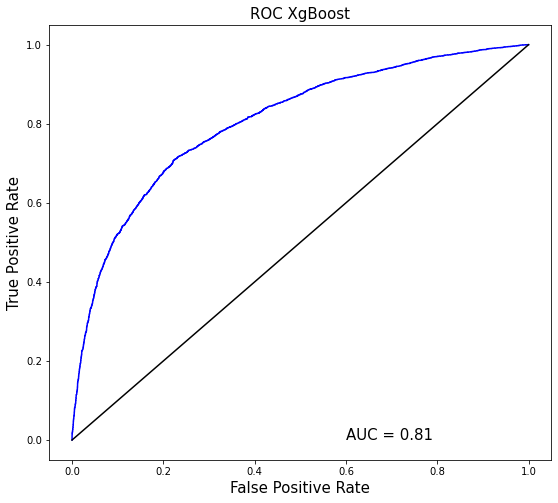

In [125]:
predictions_xgboost = xgb.predict(dmatrix_test)
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

fig, ax = plt.subplots(figsize=(9, 8))

ax.plot(fpr, tpr, 'b')
ax.plot([0, 1], [0, 1], 'k')

ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)
ax.set_title('ROC XgBoost', fontsize=15)
ax.text(
s = 'AUC = ' + str(round(metrics.roc_auc_score(y_true=test_labels, y_score=predictions_xgboost),2))
    , x=0.6, y=0.0, fontsize=15
)

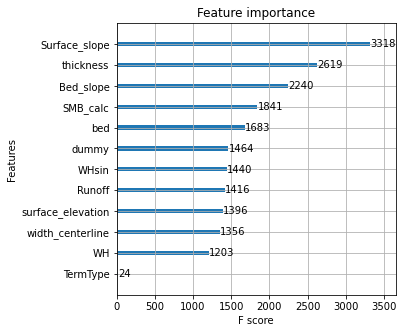

In [126]:
fig, ax = plt.subplots(figsize=(5, 5))
xgboost.plot_importance(xgb, ax=ax)

In [127]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    cbar = plt.colorbar(aspect=4)
    plt.clim(0,100)
    cbar.set_label('Fraction (%)')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[43  6]
 [21 28]]


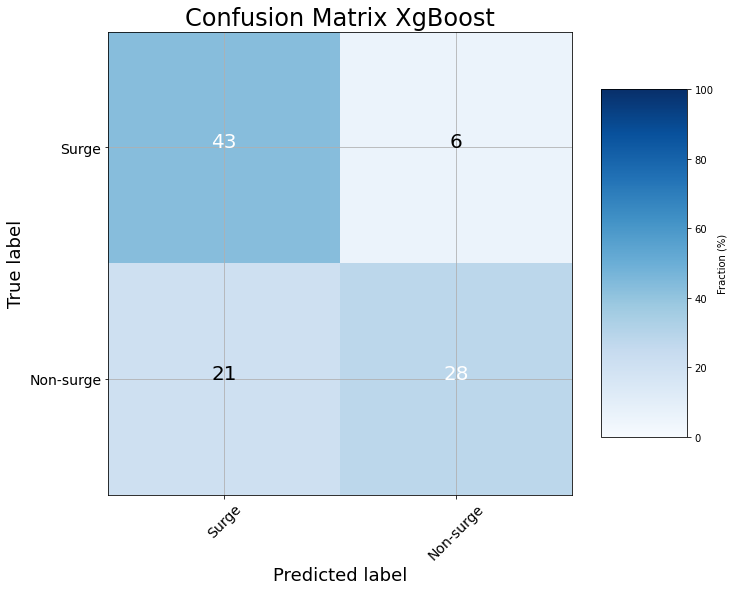

In [128]:
cm_xgboost = confusion_matrix(test_labels, predictions_xgboost.round())
plot_confusion_matrix((cm_xgboost/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix XgBoost', cmap='Blues')

### Recursively delete feature and rerun the model to see the AUC

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [39]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test, label=test_labels)

In [40]:
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}
xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

In [41]:
predictions_xgboost = xgb.predict(dmatrix_test)
fpr, tpr, t = metrics.roc_curve(y_true=test_labels, y_score=predictions_xgboost)

In [42]:
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)

/usr/local/lib64/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
import warnings
warnings.filterwarnings('ignore')

AUC=[]

# Fit model using each importance as a threshold
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    print(thresh)
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train)
    # train model
    selection_model = xgboost.XGBClassifier(**params)
    selection_model.fit(select_X_train, train_labels)
    # eval model
    select_X_test = selection.transform(test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(test_labels, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    AUC.append(metrics.roc_auc_score(y_true=test_labels, y_score=predictions))


0.0
Thresh=0.000, n=12, Accuracy: 71.87%
0.0
Thresh=0.000, n=12, Accuracy: 71.87%
0.011799174
Thresh=0.012, n=10, Accuracy: 71.87%
0.012142598
Thresh=0.012, n=9, Accuracy: 71.85%
0.013076765
Thresh=0.013, n=8, Accuracy: 71.72%
0.015590864
Thresh=0.016, n=7, Accuracy: 71.80%
0.03496344
Thresh=0.035, n=6, Accuracy: 71.80%
0.04414395
Thresh=0.044, n=5, Accuracy: 71.59%
0.09326058
Thresh=0.093, n=4, Accuracy: 71.35%
0.14639154
Thresh=0.146, n=3, Accuracy: 70.21%
0.3102026
Thresh=0.310, n=2, Accuracy: 67.83%
0.3184285
Thresh=0.318, n=1, Accuracy: 64.28%


In [44]:
AUC.reverse()
AUC

[0.6427936930934932,
 0.6783255607372862,
 0.7020874972240729,
 0.7135243171219189,
 0.7158560959360426,
 0.7179658005773929,
 0.7179658005773928,
 0.7171885409726849,
 0.7185209860093271,
 0.7187430601821008,
 0.7187430601821008,
 0.7187430601821008]

ValueError: x and y must have same first dimension, but have shapes (11,) and (12,)

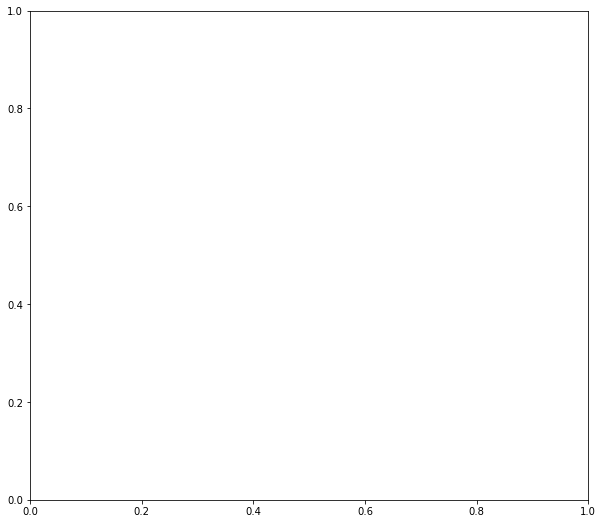

In [45]:
nb_features = np.arange(1, 12, 1)

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(nb_features, AUC, color='k')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('Number of features', fontsize=15)
ax.set_xticks(nb_features)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

AUC=[]

# Fit model using each importance as a threshold
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    print(thresh)
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(train)
    select_X_test = selection.transform(test)
    
    #Build matrix
    dmatrix_train = xgboost.DMatrix(select_X_train, label=train_labels)
    dmatrix_test = xgboost.DMatrix(select_X_test, label=test_labels)
    
    # train model
    selection_model = xgboost.train(params, dmatrix_train, num_boost_round=20000)

    # eval model
    predictions = selection_model.predict(dmatrix_test)
#     accuracy = accuracy_score(test_labels, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    AUC.append(metrics.roc_auc_score(y_true=test_labels, y_score=predictions))

In [ ]:
AUC.reverse()
AUC

In [ ]:
nb_features = np.arange(1, 12, 1)

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot(nb_features, AUC, color='k')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('Number of features', fontsize=15)
ax.set_xticks(nb_features)
ax.set_title('Features: Slope/WHsin/Thick./Bed/Runoff/Width/Dummy/SMB/WH/Surf/Terminus', fontsize=15)
ax.grid()

In [ ]:
# rfe = RFE(xgb,4)
# rfe = rfe.fit(train_reduced, train_labels)

# print(rfe.support_)
# print(rfe.ranking_)

In [ ]:
# temp = pd.Series(rfe.support_,index = train_reduced.columns)
# selected_features_rfe = temp[temp==True].index
# print(selected_features_rfe)